# Detection of Bruxism events in Tinnitus patients polysomnographic data
This notebook will 
- load EMG channels of polusomnographic data
- detect the EMG bursts in a unsupervised way
- classify EMG bursts as different bruxism events
- give insights on the bruxism events

In [28]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib qt
import numpy as np
import mne
import scipy
import seaborn as sns
from tinnsleep.config import Config
from tinnsleep.data import CreateRaw, RawToEpochs_sliding, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.classification import AmplitudeThresholding
from tinnsleep.signal import rms
from tinnsleep.visualization import plotTimeSeries, plotAnnotations, zoom_effect
from tinnsleep.utils import fuse_with_classif_result, merge_labels_list
from tinnsleep.reports import preprocess, generate_bruxism_report
from IPython.core.display import display
from ipywidgets import widgets
print("Config loaded")

print(Config.bruxisme_files[:15])

Config loaded
['E:/Acou_sommeil/EDF_V2_PAUL\\1BA07_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1BA07_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1CC05_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1CC05_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1DA15_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1DA15_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1DL12_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1DL12_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1GB18_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1GB19_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1GF14_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1GF14_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1MA16_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1MA16_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1MF19_nuit_hab.edf']


## Load, filter, and prepare data

Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\1BA07_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-43-01e729186757>:4: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading


Data filtered
keeping 8.83 hours of recording out of 8.83 hours
0.0


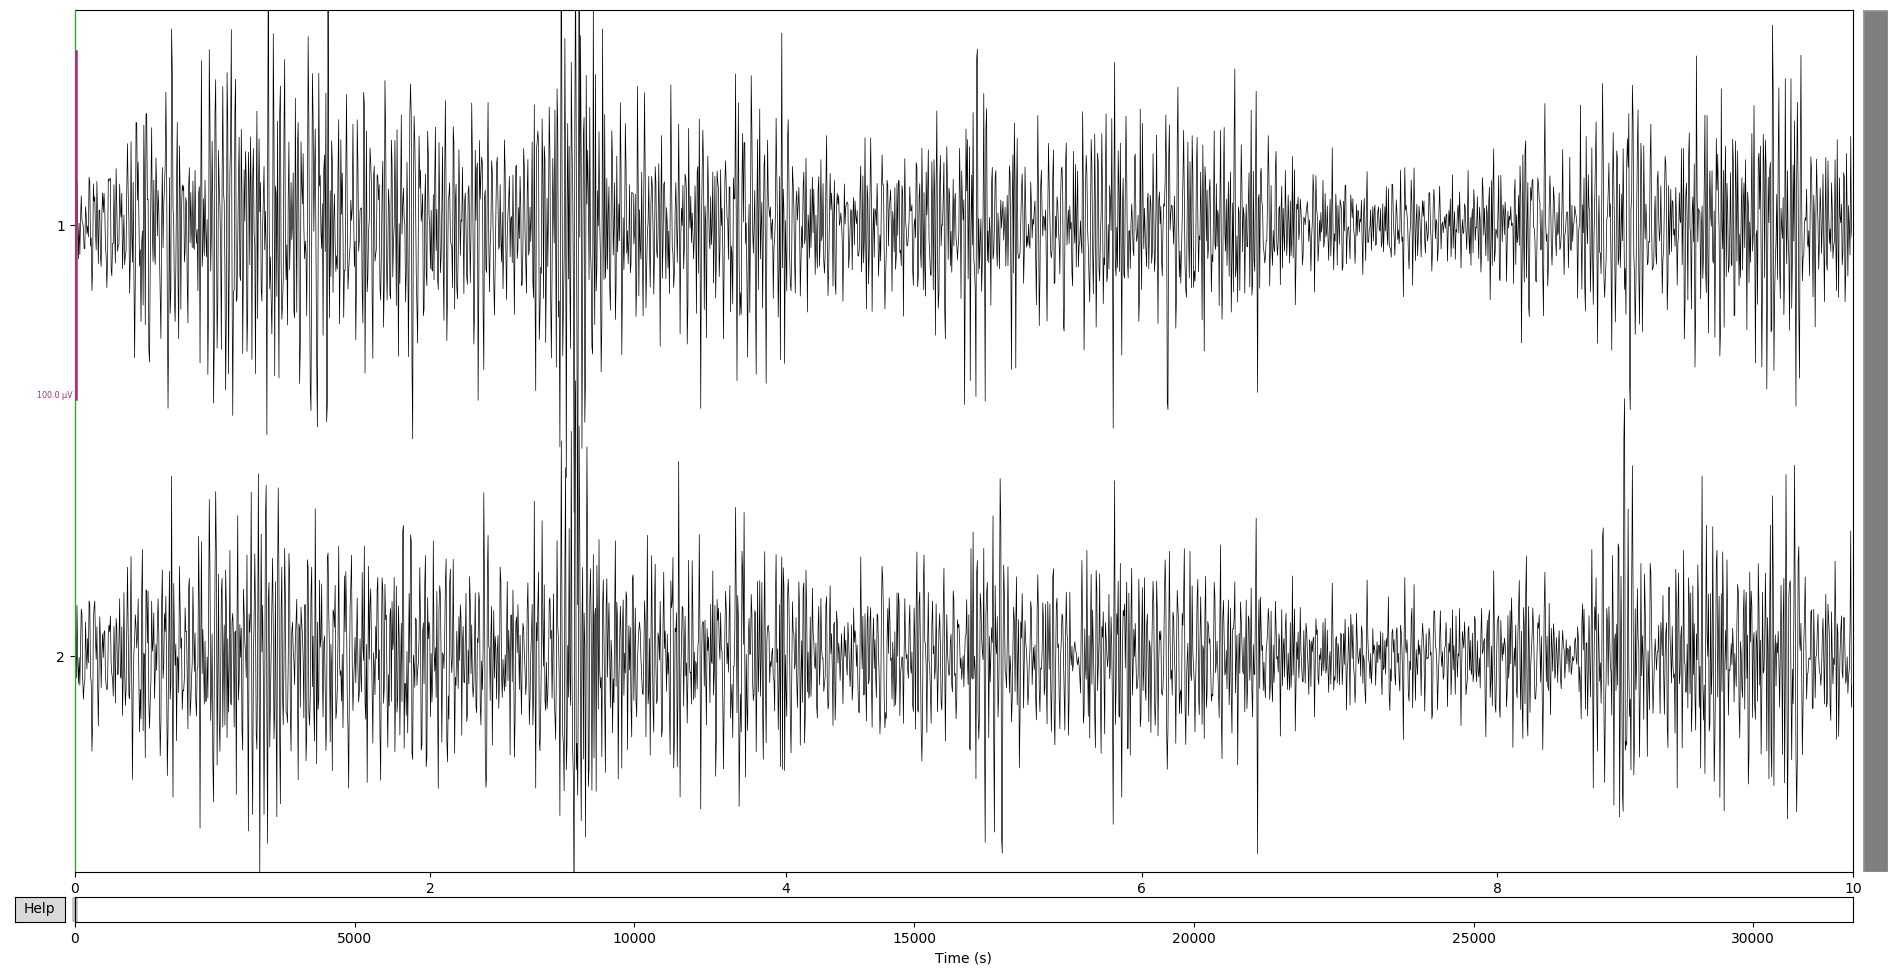

In [43]:
filename = Config.bruxisme_files[0]  # load file from config
picks_chan = ['1', '2']           # subset of EMG electrodes

raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
tmin = raw.times[0]                     
tmax = raw.times[-1]

#croptimes=dict(tmin=raw.times[0], tmax=raw.times[0]+500)
#raw.crop(**croptimes)

raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types='emg')        # pick channels and load

raw  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=picks_chan)
ch_names = raw.info["ch_names"]
print("Data filtered")

offset = raw.times[0]
print(f"keeping {(raw.times[-1]-raw.times[0])/3600:0.2f} hours of recording out of {(tmax-tmin)/3600:0.2f} hours")
print(offset)
raw.plot(scalings=dict(emg=5e-5))

## Epoching data

In [30]:
sfreq = raw.info["sfreq"]
print(sfreq)
duration = int(sfreq/4)   # in samples
interval = duration                     # no overlapping
window_length = duration/sfreq                    # in seconds
print(window_length)
epochs = RawToEpochs_sliding(raw, duration=duration, interval=interval)
print(f"Epochs done, shape {epochs.shape}")


200.0
0.25
Epochs done, shape (130240, 2, 50)


## Get the impedance & artefacts annotations

In [31]:
# Value of the impedance threshold
THR_imp = dict(abs_threshold=20000, rel_threshold=0, n_adaptive=0,
                               decision_function=lambda foo: np.any(foo>0, axis=-1))

raw_imp  = mne.io.read_raw_edf(filename, preload=False,  verbose=False)  # prepare loading
ch_names = raw_imp.info["ch_names"]
picks_chan = [ch_names[1],ch_names[5]]
print(picks_chan)
raw_imp  = CreateRaw(raw_imp[picks_chan][0], raw_imp.info["sfreq"], picks_chan, ch_types='emg') 

#croptimes=dict(tmin=raw_imp.times[0]+3600*2, tmax=raw_imp.times[-1]-3600)
#raw_imp.crop(**croptimes)

#Get the table of bad electrodes booleans from the impedance thresholding algo
epochs_imp, impedance_labels, log = preprocess(raw_imp, duration, interval,
                                        picks_chan="all",
                                        is_good_kwargs=None,
                                        filter_kwargs=None,
                                        Thresholding_kwargs=THR_imp,
                                        burst_to_episode_kwargs=None,
                                        merge_fun=None)
print(impedance_labels[-20:])

# convert to labels per epoch
print(f"Good impedances for {np.sum(impedance_labels)} epochs out of {len(impedance_labels)} ({np.sum(impedance_labels)/len(impedance_labels)*100:.2f}%)")

<ipython-input-31-054f17b6d3f5>:5: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw_imp  = mne.io.read_raw_edf(filename, preload=False,  verbose=False)  # prepare loading


['1 Imp?dance', '2 Imp?dance']
[False False False False False False False False False False False False
 False False False False False False False False]
Good impedances for 130010 epochs out of 130240 (99.82%)


## OMA rejection

<ipython-input-32-57bea551860e>:5: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw_OMA  = mne.io.read_raw_edf(filename, preload=False,  verbose=False)  # prepare loading


['Activity']
200
[False False False False False False False False False False  True  True
  True False  True  True  True  True  True  True]
epochs without OMA for 31755 epochs out of 32560 (97.53%)
Raw annotated


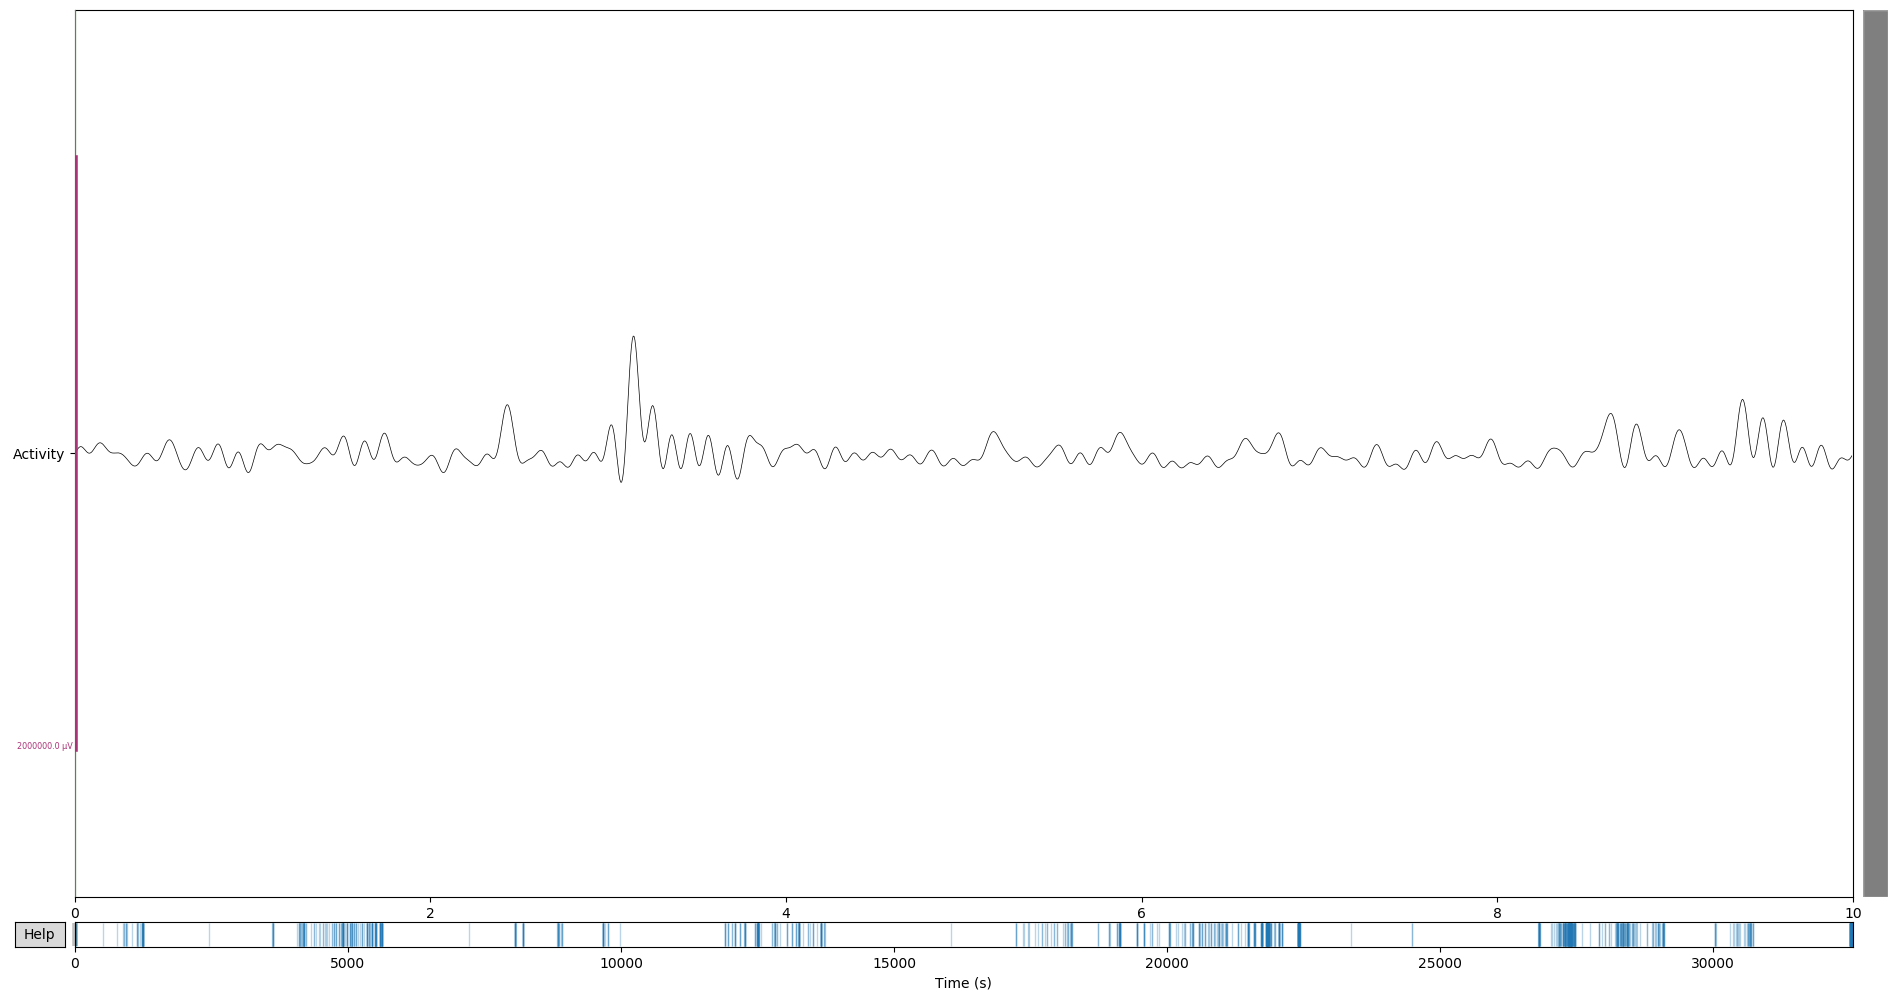

In [32]:
# Value of the impedance threshold
THR_OMA = dict(abs_threshold=0, rel_threshold=3, n_adaptive=0,
                               decision_function=lambda foo: np.any(foo>0, axis=-1))

raw_OMA  = mne.io.read_raw_edf(filename, preload=False,  verbose=False)  # prepare loading
ch_names = raw_OMA.info["ch_names"]
picks_chan = ["Activity"]
print(picks_chan)
raw_OMA  = CreateRaw(raw_OMA[picks_chan][0], raw_OMA.info["sfreq"], picks_chan, ch_types='emg') 

#croptimes=dict(tmin=raw_OMA.times[0]+3600*2, tmax=raw_OMA.times[-1]-3600)
#raw_OMA.crop(**croptimes)

duration_OMA = int(sfreq/4)*4
interval_OMA = duration_OMA
print(duration_OMA)

burst_to_episode_kwargs = dict()

#Get the table of bad electrodes booleans from the impedance thresholding algo
epochs_OMA, OMA_labels, log = preprocess(raw_OMA, duration_OMA, interval_OMA,
                                        picks_chan="all",
                                        is_good_kwargs=None,
                                        filter_kwargs=None,
                                        Thresholding_kwargs=THR_OMA,
                                        burst_to_episode_kwargs = dict(min_burst_joining=0),
                                        merge_fun=None)
print(OMA_labels[-20:])

# convert to labels per epoch
print(f"epochs without OMA for {np.sum(OMA_labels)} epochs out of {len(OMA_labels)} ({np.sum(OMA_labels)/len(OMA_labels)*100:.2f}%)")

dict_annotations = {1: "OMA"}
raw_OMA = CleanAnnotations(raw_OMA)
raw_OMA = AnnotateRaw_sliding(raw_OMA, np.invert(OMA_labels), 
                dict_annotations=dict_annotations, duration=duration_OMA, interval=interval_OMA)
print("Raw annotated")
raw_OMA.plot(scalings=dict(emg=1))

In [109]:
# baseline epochs amplitudes
print(f"mean {np.mean(np.mean(epochs, axis=0), axis=-1)}")
print(f"median {np.median(np.median(epochs, axis=0), axis=-1)}")
print(f"quantile 0.05 {np.quantile(np.quantile(epochs, 0.05, axis=0),0.05, axis=-1)}")
print(f"quantile 0.95 {np.quantile(np.quantile(epochs, 0.95, axis=0),0.95, axis=-1)}")

mean [2.30414402e-12 3.24563032e-12]
median [9.67573730e-08 9.94110767e-08]
quantile 0.05 [-7.01635187e-06 -7.04417688e-06]
quantile 0.95 [6.78342177e-06 6.88616335e-06]


In [33]:
# Epoch rejection based on |min-max| thresholding 
from tinnsleep.signal import is_good_epochs
params = dict(ch_names=raw.info["ch_names"],
             rejection_thresholds=dict(emg=5e-04), # two order of magnitude higher q0.01
             flat_thresholds=dict(emg=1e-09),    # one order of magnitude lower median
             channel_type_idx=dict(emg=[0, 1]),
             full_report=True
            )
amplitude_labels, bad_lists = is_good_epochs(epochs, **params)
print(amplitude_labels[:10])
print(bad_lists[:10])
print(f"good amplitudes for {np.sum(amplitude_labels)} epochs out of {len(amplitude_labels)} ({np.sum(amplitude_labels)/len(amplitude_labels)*100:.2f}%)")

[True, True, True, True, True, True, True, True, True, True]
[None, None, None, None, None, None, None, None, None, None]
good amplitudes for 129984 epochs out of 130240 (99.80%)


## Merging preprocessing steps 

In [37]:
import time
#----------------- Merging artifacts labels ------------------------------------------
valid_labels=[amplitude_labels, impedance_labels, OMA_labels]
print(len(epochs))
print(len(amplitude_labels))
resampling_factors = [int(len(epochs)/len(i)) for i in valid_labels]  # compute all resampling factors
print(resampling_factors)
min_labels = min([len(i)*j for (i, j) in zip(valid_labels, resampling_factors)])  # find the common denominator
print(min_labels)
assert (len(epochs) - min_labels) < max(resampling_factors), f"shift of {len(epochs) - min_labels} epochs, please check that all duration are proportional"
epochs = epochs[:min_labels]  # crop last epochs
valid_labels = [i[:int(min_labels/j)] for (i, j) in zip(valid_labels, resampling_factors)]  # crop valid_labels
assert len(epochs) == min_labels, f"something went wrong when cropping"
# print(f"resampling_factors: {resampling_factors}, min_label {min_labels}, final {[len(i) for i in valid_labels]}")
valid_labels = merge_labels_list(valid_labels, len(epochs))
print("DONE")

print(f"good epochs for {np.sum(valid_labels)} epochs out of {len(valid_labels)} ({np.sum(valid_labels)/len(valid_labels)*100:.2f}%)")
print(valid_labels[:3])

dict_annotations_artefacts = {1: "artefact"}
annotations_artefacts = []
for k, label in enumerate(np.invert(valid_labels)):
    if label > 0:
        annotations_artefacts.append(dict(
            onset=k*interval/sfreq,
            duration=duration/sfreq,
            description=dict_annotations_artefacts[label],
            orig_time=offset
        )
            
        )

130240
130240
[1, 1, 4]
130240
DONE
good epochs for 126846 epochs out of 130240 (97.39%)
[ True  True  True]


## Classifying epochs and annotate raw

In [38]:
# compute the sum of power over electrodes and samples in each window
epochs_adaptive = int(60 / window_length) # in epochs
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=3, n_adaptive=epochs_adaptive)
X        = rms(epochs[valid_labels]) # take only valid labels
labels   = pipeline.fit_predict(X)
labels   = fuse_with_classif_result(np.invert(valid_labels), labels) # add the missing labels removed with artefacts
print(f"bursts count: {np.sum(labels)}/{len(labels)} ({np.sum(labels) / len(labels) * 100:.2f}%)")
print(f"bursts time: {np.sum(labels) * window_length} seconds")

dict_annotations = {1: "burst"}
annotations = []
for k, label in enumerate(labels):
    if label > 0:
        annotations.append(dict(
            onset=k*interval/sfreq,
            duration=duration/sfreq,
            description=dict_annotations[label],
            orig_time=offset
        )
            
        )

bursts count: 1552/130240 (1.19%)
bursts time: 388.0 seconds


## Generate clinical report

In [42]:
generate_bruxism_report(labels, window_length, delim = 3)

C:\Users\Zeta\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Zeta\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'Clean data duration': 21349.824,
 'Total burst duration': 105.4,
 'Total number of burst': 162,
 'Number of bursts per hour': 27.316384434831875,
 'Total number of episodes': 20,
 'Number of bursts per episode': 8.1,
 'Number of episodes per hour': 3.3723931401027007,
 'Number of tonic episodes per hour': 0.0,
 'Number of phasic episodes per hour': 0.5854474491218289,
 'Number of mixed episodes per hour': 0.25090604962364094,
 'Mean duration of tonic episode': nan,
 'Mean duration of phasic episode': 5.402857142857296,
 'Mean duration of mixed episode': 8.142666666666893}

## Display Bursts

In [40]:
def plotBursts(raw, annotations, annotations_artefacts, plotargs):
    ax1 = plt.subplot(211)
    plotTimeSeries(raw.get_data().T, ax=ax1,**plotargs)
    plotAnnotations(annotations_artefacts, ax=ax1, color="red")
    plotAnnotations(annotations,ax=ax1, text_prop=dict(color="green"), color="green")

    ax1.set_xlim(5145,5165)
    ax2 = plt.subplot(212)
    plotTimeSeries(raw.get_data().T, ax=ax2,**plotargs)
    z = zoom_effect(ax1, ax2)

    from ipywidgets import interact, FloatSlider
    def update_axis(xmin, xmax):
        if xmin<xmax:
            ax1.set_xlim(xmin,xmax)

    i=FloatSlider(min=raw.times[0], max=raw.times[-1], step=10, continuous_update=False)
    ii=FloatSlider(min=raw.times[0], max=raw.times[-1], step=10, continuous_update=False)
    from ipywidgets import FloatSlider
    interact(update_axis,xmin=i, xmax=ii);
    return ax1, ax2

In [41]:
plt.close("all")

# decimate signal to make it more readible 
raw_ds = raw.copy().resample(100)

%matplotlib widget
scalings=1e-5
plotargs = dict(sfreq=raw_ds.info["sfreq"], scalings=scalings, offset=offset, linewidth=0.5)
plt.figure()
ax1, ax2 = plotBursts(raw_ds, annotations, annotations_artefacts, plotargs);
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='xmin', max=20949.99, step=1…

## Display Episodes

## Transform classif to episodes

1BA07_nuit_hab In this example, an episode of half an hour is detected between 1400 and 3500.

In [43]:
from tinnsleep.events.scoring import classif_to_burst, burst_to_episode
bursts = classif_to_burst(labels, time_interval=window_length)
annotations_episodes = [episode.generate_annotation(orig_time=offset) for episode in burst_to_episode(bursts)]
print(annotations_episodes[:3])

[{'onset': 291.5, 'duration': 14.75, 'description': 'Mixed', 'orig_time': 0.0}, {'onset': 403.75, 'duration': 8.25, 'description': 'Mixed', 'orig_time': 0.0}, {'onset': 440.25, 'duration': 4.0, 'description': 'Phasic', 'orig_time': 0.0}]


In [44]:
#plt.close("all")
scalings=5e-5
print(offset)
plotargs = dict(sfreq=raw_ds.info["sfreq"], scalings=scalings, offset=offset, linewidth=0.5)
plt.figure()
plt.title("artefacts (red), episodes (green)")
ax3, ax4 = plotBursts(raw_ds, annotations_episodes, annotations_artefacts, plotargs)
ax3.set_xlim(10000,10200);
plt.show()

0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='xmin', max=20949.99, step=1…

In [34]:
print(OMA_labels[:100])
OMAs=[]
for elm in np.invert(OMA_labels):
    if elm:
        OMAs.append(2)
    else:
        OMAs.append(0)
print(OMAs[:100])
print(np.sum(OMAs)/2)

good=[]
for elm in np.invert(amplitude_labels):
    if elm:
        good.append(3)
    else:
        good.append(0)

print(np.sum(good)/3)
print(np.sum(np.invert(impedance_labels)))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
805.0
256.0
230


In [41]:

from tinnsleep.events.scoring import classif_to_burst, burst_to_episode, episodes_to_list
bursts = classif_to_burst(labels, time_interval=window_length)
li_ep=burst_to_episode(bursts)
lab_ep = episodes_to_list(li_ep, 0.250, int(len(labels)))
print()
print(np.sum(labels))
print(len(labels))
print(len(lab_ep))



1552
130240
130240


Raw annotated


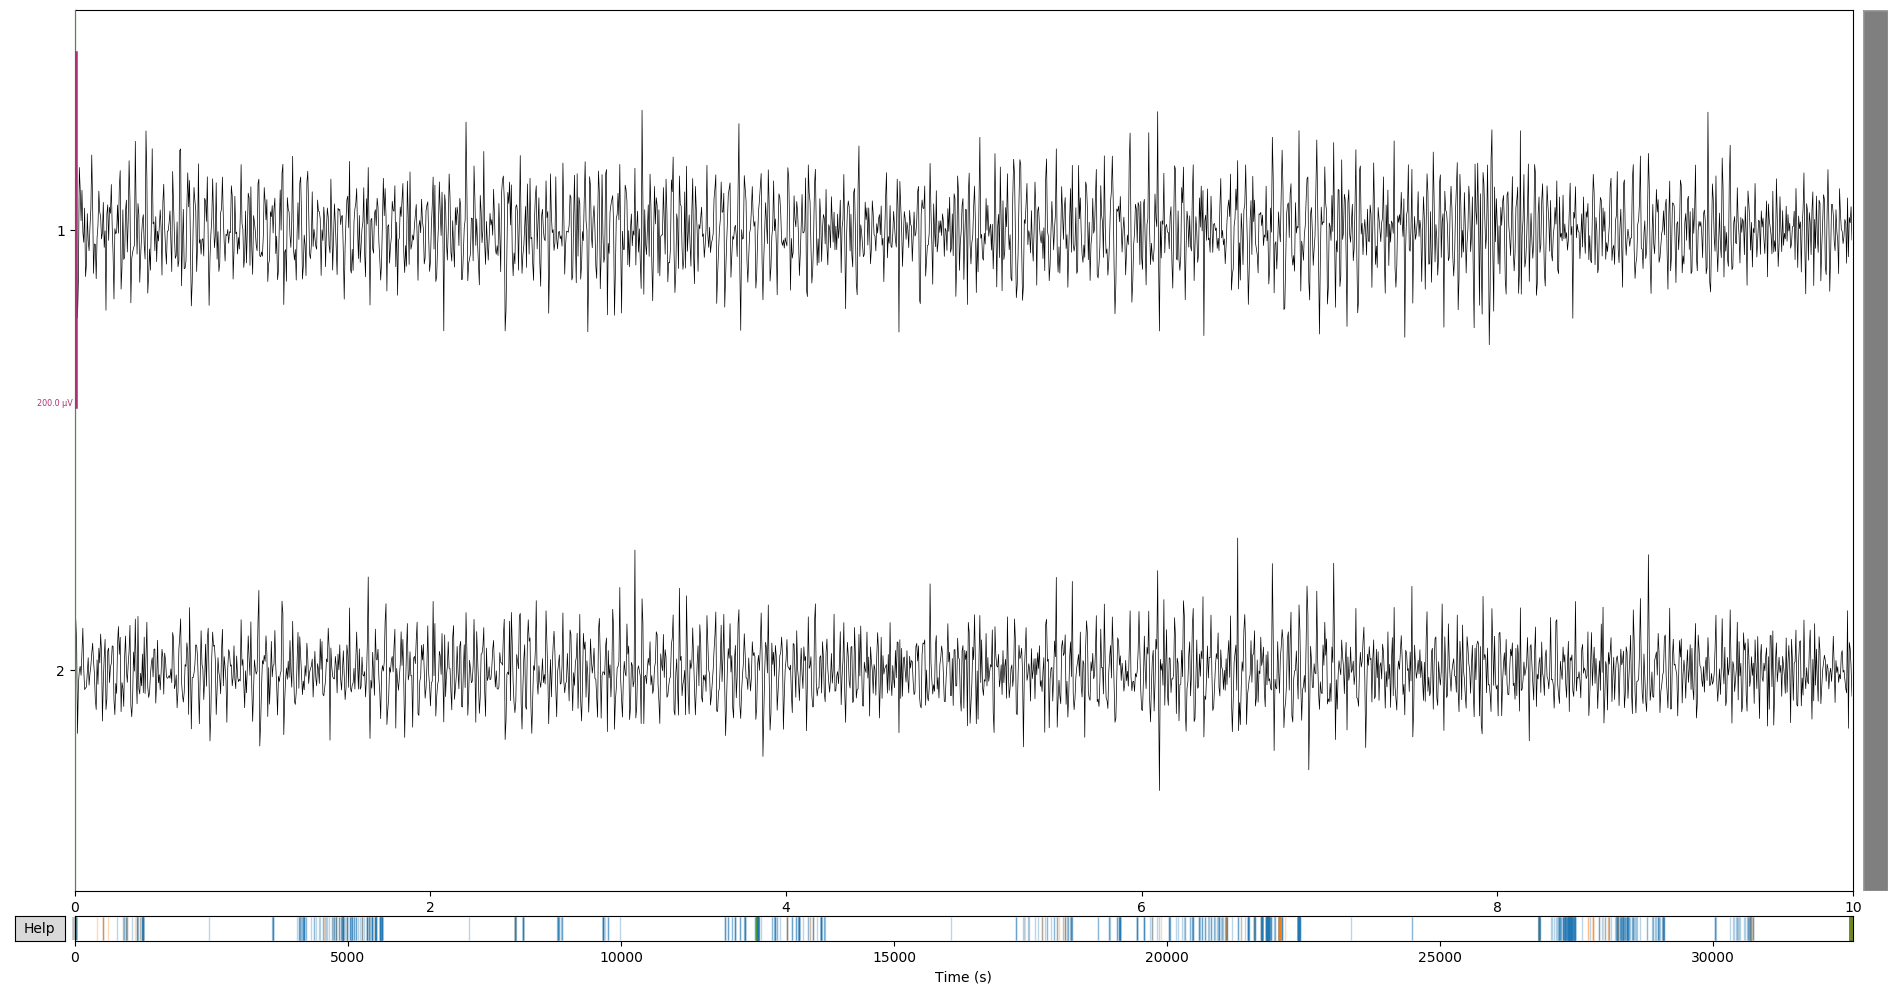

In [35]:
raw = CleanAnnotations(raw)
raw = AnnotateRaw_sliding(raw, good, 
                dict_annotations=dict_annotations, duration=duration, interval=interval)
raw = AnnotateRaw_sliding(raw, OMAs, 
                dict_annotations=dict_annotations, duration=duration_OMA, interval=interval_OMA)
raw = AnnotateRaw_sliding(raw, np.invert(impedance_labels), 
                dict_annotations=dict_annotations, duration=duration, interval=interval)
print("Raw annotated")
raw.plot(scalings=dict(emg=1e-4))

Raw annotated


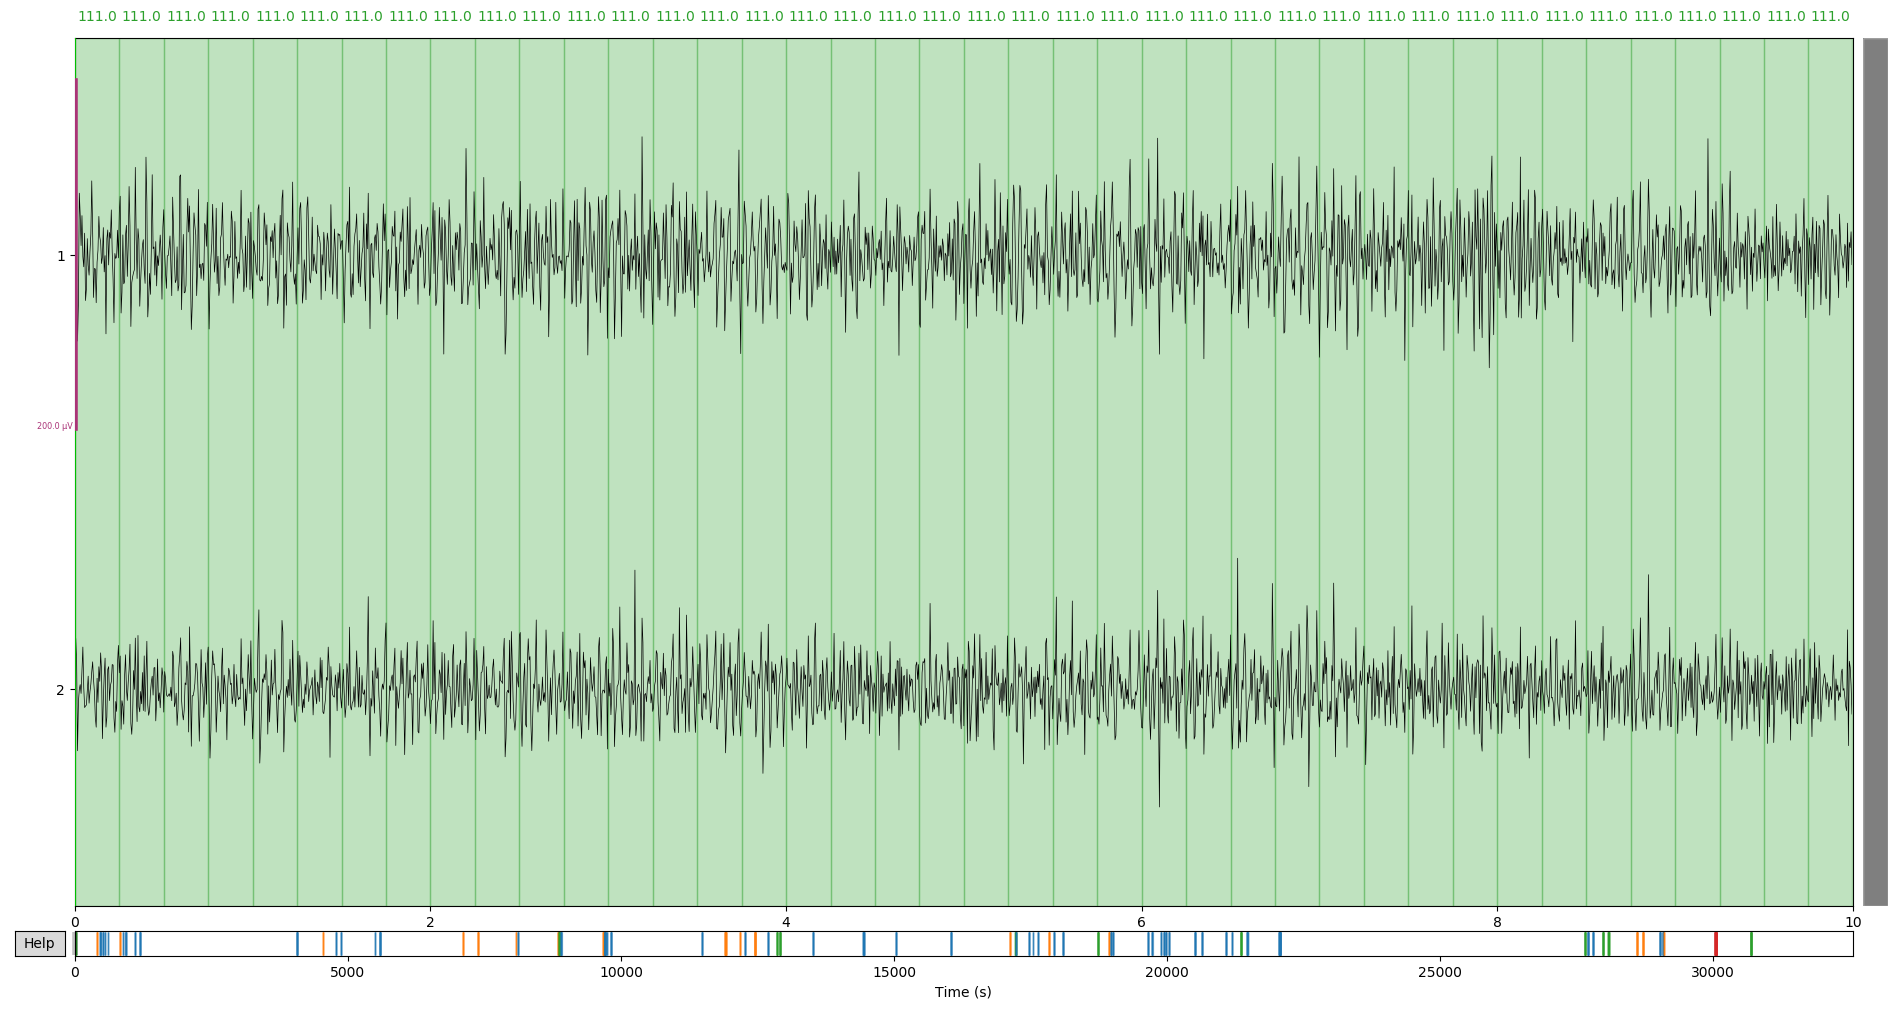

In [42]:
raw = CleanAnnotations(raw)
raw = AnnotateRaw_sliding(raw, lab_ep, 
                dict_annotations=dict_annotations, duration=duration, interval=interval)
print("Raw annotated")
raw.plot(scalings=dict(emg=1e-4))

In [15]:
%matplotlib qt